In [20]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np


In [ ]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [21]:
data_clean = pd.read_csv('../data/data_clean.csv', parse_dates=['date'])

## Creación de nuevas variables
Modelo Base

In [22]:
data_base = data_clean.copy()

In [23]:
data_base.columns
len(data_base)

13037

En primer lugar, transformaremos ciertas variables fundamentales en variaciones año sobre año. Esto se debe a que el valor absoluto no es tan bueno estimando como el ritmo de crecimiento según la literatura

In [24]:
import numpy as np

# Ordenar primero por ticker y fecha
data_base = data_base.sort_values(['ticker', 'date'])

# 0. Risk Free Rate a Decimal
data_base['risk_free_rate'] = data_base['risk_free_rate'] / 100


# 1. Crecimientos YoY para variables fundamentales
#for col in ['revenue', 'ebitda','ebit', 'eps', 'equity', 'capex', 'pe', 'pb', 'fcfps', 'ncfo']:
#    data_base[f'{col}_yoy'] = data_base.groupby('ticker')[col].pct_change()

# 2. Transformaciones logarítmicas
for col in ['revenue', 'ebitda', 'ebit', 'marketcap', 'equity']:
    data_base[f'signed_log_{col}'] = np.sign(data_base[col]) * np.log1p(np.abs(data_base[col]))



# 3. Ratios financieros 
data_base['ebit_margin'] = data_base['ebit'] / data_base['revenue']
data_base['net_margin'] = data_base['netinc'] / data_base['revenue']
data_base['capex_to_revenue'] = data_base['capex'] / data_base['revenue']

# 4. FCF Yield 
data_base['fcf_yield'] = data_base['fcfps'] / data_base['closeadj']

# 5. Price to Sales Ratio
data_base['ps'] = data_base['marketcap'] / data_base['revenue']

# 6. Combinaciones retorno/volatilidad
data_base['ret_12m_vol'] = data_base['ret_12m'] / data_base['volatility_1y']
data_base['ret_6m_vol'] = data_base['ret_6m'] / data_base['volatility_1y']

# 7. Diferencia de medias móviles
data_base['sma_diff'] = data_base['sma_1y'] - data_base['sma_2y']

# 8. Distancia al máximo/mínimo anual
data_base['dist_max_1y'] = data_base['closeadj'] / data_base['max_1y']
data_base['dist_min_1y'] = data_base['closeadj'] / data_base['min_1y']

# 8. Volatilidad relativa
data_base['vol_over_sma'] = data_base['volatility_1y'] / data_base['sma_1y']

# 9. Tamaño por percentil 


p90 = data_base['marketcap'].quantile(0.9)
p70 = data_base['marketcap'].quantile(0.7)
p30 = data_base['marketcap'].quantile(0.3)


def cap_category(marketcap):
    if marketcap >= p90:
        return 'Mega Cap'
    elif marketcap >= p70:
        return 'Large Cap'
    elif marketcap >= p30:
        return 'Mid Cap'
    else:
        return 'Small Cap'

data_base['cap_category'] = data_base['marketcap'].apply(cap_category)
dummies = pd.get_dummies(data_base['cap_category'], prefix='cap')
data_base = pd.concat([data_base, dummies], axis=1)





In [25]:
data_base.isna().sum().sum()

0

In [26]:

# 10. Target Return Label
data_base['target_class'] = data_base.groupby('date')['target_12m_final'].transform(
    lambda x: pd.qcut(x, 5, labels=[0,1,2,3,4])
)



In [27]:
data_base.columns

Index(['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'roe',
       'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'target_12m_final',
       'sharpe_1y', 'signed_log_revenue', 'signed_log_ebitda',
       'signed_log_ebit', 'signed_log_marketcap', 'signed_log_equity',
       'ebit_margin', 'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps',
       'ret_12m_vol', 'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y',
       'vol_over_sma', 'cap_category', 'cap_Large Cap', 'cap_Mega Cap',
       'cap_Mid Cap', 'cap_Small Cap', 'target_class'],
      dtype='object')

In [28]:
data_base.isna().sum().sum()


0

Al crear variables logarítmicas optenemos nan's y valores infinitos. El primer aproximamiento va a ser eliminarlas 

Para evitar esto se ha usado signed_logs :   signed_log(x)=sign(x)×log(1+∣x∣)


In [29]:
len(data_base)

13037

Se ha decidio omitir de momento sharpe_1y y realizar los modelos con target_class como objetivo

In [30]:
data_base.drop(columns=['sharpe_1y'], inplace=True)


In [31]:
features = [
    # Variables financieras, rendimientos, volatilidades:
    'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y', 'volatility_1y',
    'revenue', 'eps', 'ebitda', 'netinc',   'fcfps', 
    'marketcap', 'ebit', 'capex', 'ncfo', 'equity', 
    
    # Value
    'pb', 'pe','ps','evebitda',
    
    # Solvencia
    'de',
    
    # Year-over-Year growth:
    'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy', 'equity_yoy', 'capex_yoy',
    'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
    
    # Retornos, riesgo:
    'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 
    
    # Variables logarítmicas simétricas:
    'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit',
    'signed_log_marketcap', 'signed_log_equity',
    
    # Ratios financieros y márgenes:
    'roe','ebit_margin', 'net_margin',  'fcf_yield',
    
    # Esfuerzos de inversión: 
    'capex_to_revenue',
    
    # Volatilidades, distancias, momentum:
    'ret_12m_vol', 'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma',
    
    # Dummies de categorías de tamaño de capitalización:
    'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap', 'cap_Small Cap'
    
]

c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


volatility_1y           0.252384
dist_max_1y             0.243322
risk_free_rate          0.179264
ret_6m                  0.151172
ret_12m                 0.148316
signed_log_marketcap    0.108448
fcf_yield               0.106143
vol_over_sma            0.102781
ret_12m_vol             0.101720
cap_Small Cap           0.099787
ret_6m_vol              0.089313
ps                      0.082125
signed_log_ebit         0.075287
signed_log_ebitda       0.068087
revenue_yoy             0.061943
cap_Mid Cap             0.048527
vol_1y                  0.046721
sma_diff                0.046705
ebit_margin             0.038828
closeadj                0.038771
dtype: float64


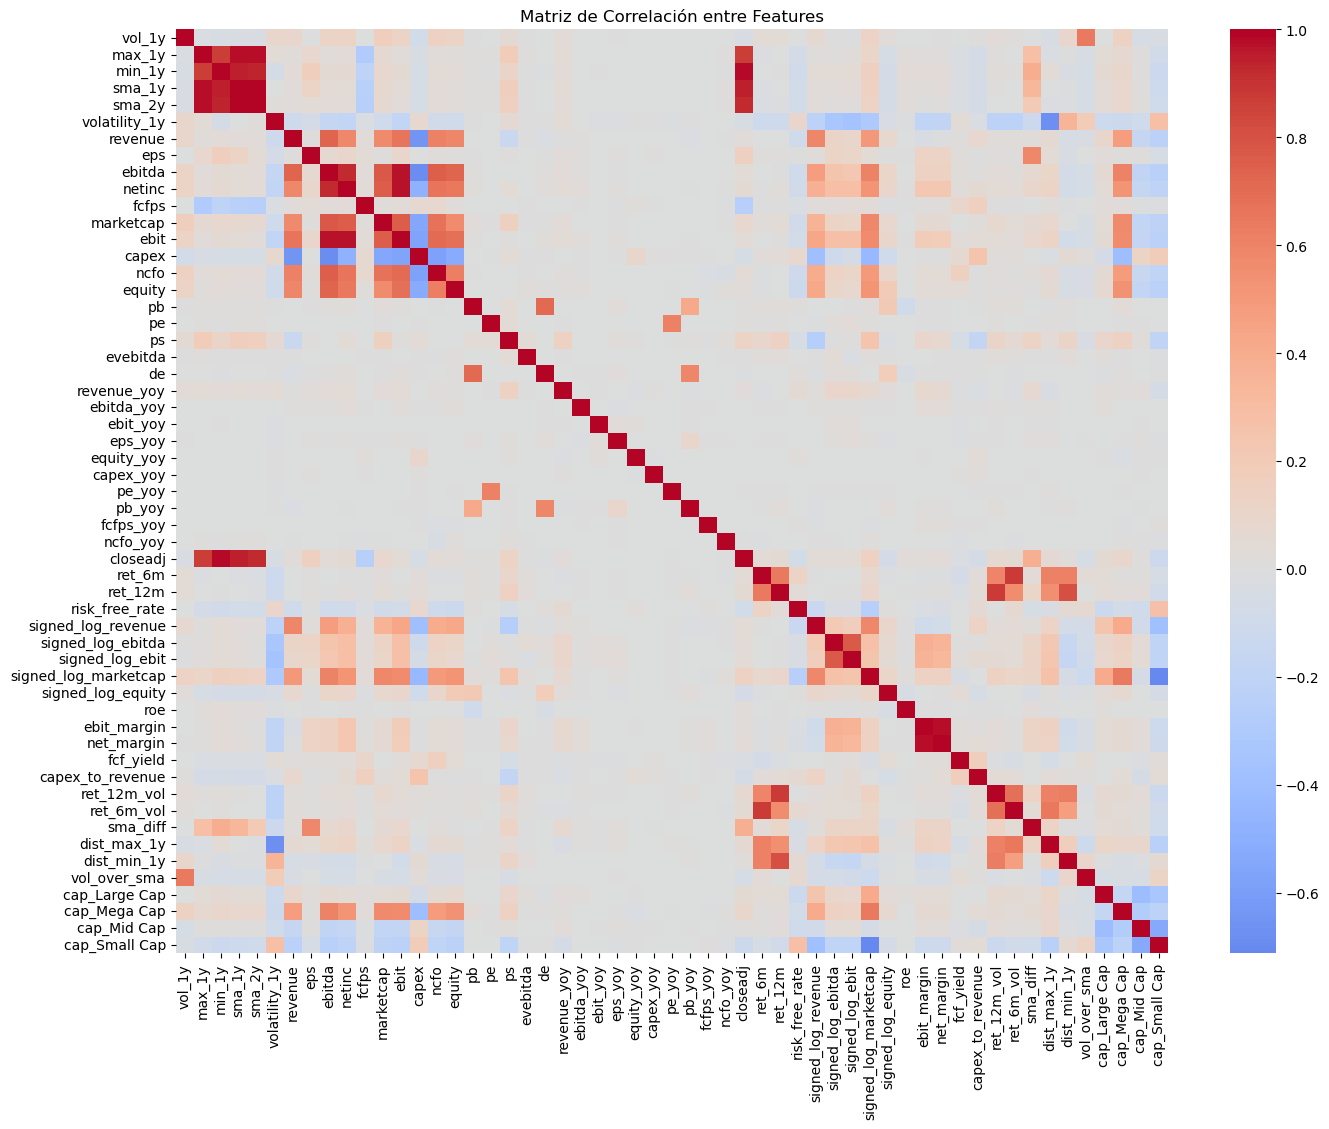

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Dataset (X: features, y: target)
x = data_base[features]
y = data_base['target_12m_final']

# 2. Correlación de cada feature con el target
corr_with_target = x.corrwith(y)

# Ordenar de mayor a menor correlación absoluta
corr_with_target_sorted = corr_with_target.abs().sort_values(ascending=False)

# Mostrar las top 20 variables más correlacionadas con el target
print(corr_with_target_sorted.head(20))

# 3. Matriz de correlación entre todas las features
corr_matrix = x.corr()

# 4. Plot de la matriz de correlación entre features (opcional, heatmap bonito)
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title('Matriz de Correlación entre Features')
plt.show()


In [34]:
X = data_base[features]
print(X.columns.tolist())


['vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y', 'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'fcfps', 'marketcap', 'ebit', 'capex', 'ncfo', 'equity', 'pb', 'pe', 'ps', 'evebitda', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy', 'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy', 'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit', 'signed_log_marketcap', 'signed_log_equity', 'roe', 'ebit_margin', 'net_margin', 'fcf_yield', 'capex_to_revenue', 'ret_12m_vol', 'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma', 'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap', 'cap_Small Cap']


DUDA: Con cuales me quedo?

Se han generado valores infinitos en las variables de crecimiento, dado que son pocos <30 los sustituimos con 0 indicando que en ese año no hubo crecimiento. 

In [35]:
import numpy as np

# Asegurar tipo de dato correcto
data_base.replace([np.inf, -np.inf], np.nan, inplace=True)

# Reemplazar todo lo faltante con 0
data_base.fillna(0, inplace=True)

print("Limpieza completada. NaNs e Infs reemplazados con 0.")
print("NaNs restantes:", data_base.isna().sum().sum())


Limpieza completada. NaNs e Infs reemplazados con 0.
NaNs restantes: 0


In [36]:
data_base.to_csv('../data/data_base.csv', index=False)